##  확률과 언어 모델

### word2vec을 확률관점에서 바라보기

### 언어 모델
- 단어 나열에 확률을 부여
- 자연스러울수록 높은 확률 부여

### CBOW모델을 언어 모델로
- 문장을 이해해 가는 과정에서 단어의 순서가 무시된다.

##  RNN이란

### 순환하는 신경망

### 순환 구조 펼치기

### BPTT
- 시간 방향으로 펼쳐진 신경망의 오차역전파법

### Truncated BPTT
- 순환 신경망을 잘라 여러개의 신경망을 만들어 오차 역전파법을 적용
- 신 시계열 데이터에서 메모리 부족을 해결

### Truncated BPTT의 미니배치 학습

## RNN 구현하기

### RNN 계층 구현하기

In [2]:
import numpy as np
import sys
sys.path.append('deep2')

In [3]:
class RNN:
    def __init__(self,Wx,Wh,b):
        self.params = [Wx,Wh,b]
        self.grads = [np.zero_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.cache = None
    
    def forword(self,x,h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev,Wh) + np.matmul(x,Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x,h_prev,h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next**2)
        db = np.sum(dt,axis = 0)
        dWh = np.matmul(h_prev.T,dt)
        dWx = np.matmul(x.T,dt)
        dh_prev = np.matmul(dt,Wh.T)
        dx = np.matmul(dt,Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

### TimeRNN 계층 구현

In [5]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx,Wh,b]
        self.grads = [np.zero_like(Wx),np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful
    
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N,T,D), dtype = 'f')
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype='f')
        
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forword(xs[:,t,:],self.h)
            hs[:,t,:] = self.h
            self.layers.append(layer)
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D),dtype = 'f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh)
            dxs[:,t,:] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

## 시계열 데이터 처리 계층 구현

### RNNLM의 전체 그림

## RNNLM 학습과 평가

### 구현

In [6]:
from common.time_layers import *

In [18]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D)/100).astype('f')
        rnn_Wx = (rn(D,H)/100).astype('f')
        rnn_Wh = (rn(H,H)/100).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V)/100).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx,rnn_Wh,rnn_b,stateful=True),
            TimeAffine(affine_W,affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        self.params, self.grads = [],[]
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self,xs,ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs,ts)
        return loss
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    def reset_state(self):
        self.rnn_layer.reset_state()

### 언어 모델 평가
- 퍼플렉서티 : 확률의 역수
    - 다음 단어 확률이 0.8 이라면 퍼플리서티 = 1.25

### 학습 코드

In [25]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb
from deep2.ch05.simple_rnnlm import SimpleRnnlm

In [26]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('말뭉치 크기 : %d, 어휘 수 : %d' % (corpus_size,vocab_size))

max_iters = data_size//(batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

말뭉치 크기 : 1000, 어휘 수 : 418


In [27]:
model = SimpleRnnlm(vocab_size,wordvec_size,hidden_size)
optimizer = SGD(lr)

jump = (corpus_size -1)//batch_size
offsets = [i*jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size,time_size), dtype='i')
        batch_t = np.empty((batch_size,time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i,t] = xs[(offset+time_idx) % data_size]
                batch_t[i,t] = ts[(offset+time_idx) % data_size]
            time_idx += 1
        
        loss = model.forward(batch_x,batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    ppl = np.exp(total_loss/loss_count)
    print('|epoch %d| ppl %.2f' % (epoch+1,ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0,0

|epoch 1| ppl 384.19
|epoch 2| ppl 259.32
|epoch 3| ppl 228.18
|epoch 4| ppl 217.95
|epoch 5| ppl 206.98
|epoch 6| ppl 203.41
|epoch 7| ppl 199.91
|epoch 8| ppl 197.22
|epoch 9| ppl 193.07
|epoch 10| ppl 194.43
|epoch 11| ppl 189.64
|epoch 12| ppl 194.42
|epoch 13| ppl 190.73
|epoch 14| ppl 191.42
|epoch 15| ppl 191.10
|epoch 16| ppl 187.69
|epoch 17| ppl 185.26
|epoch 18| ppl 182.24
|epoch 19| ppl 183.73
|epoch 20| ppl 185.05
|epoch 21| ppl 181.93
|epoch 22| ppl 178.84
|epoch 23| ppl 175.95
|epoch 24| ppl 177.53
|epoch 25| ppl 174.49
|epoch 26| ppl 174.56
|epoch 27| ppl 169.13
|epoch 28| ppl 167.11
|epoch 29| ppl 165.30
|epoch 30| ppl 160.58
|epoch 31| ppl 160.62
|epoch 32| ppl 154.28
|epoch 33| ppl 155.84
|epoch 34| ppl 150.03
|epoch 35| ppl 148.96
|epoch 36| ppl 142.87
|epoch 37| ppl 136.90
|epoch 38| ppl 133.60
|epoch 39| ppl 128.23
|epoch 40| ppl 123.05
|epoch 41| ppl 123.51
|epoch 42| ppl 116.45
|epoch 43| ppl 110.66
|epoch 44| ppl 107.06
|epoch 45| ppl 102.03
|epoch 46| ppl 99.8

<IPython.core.display.Javascript object>


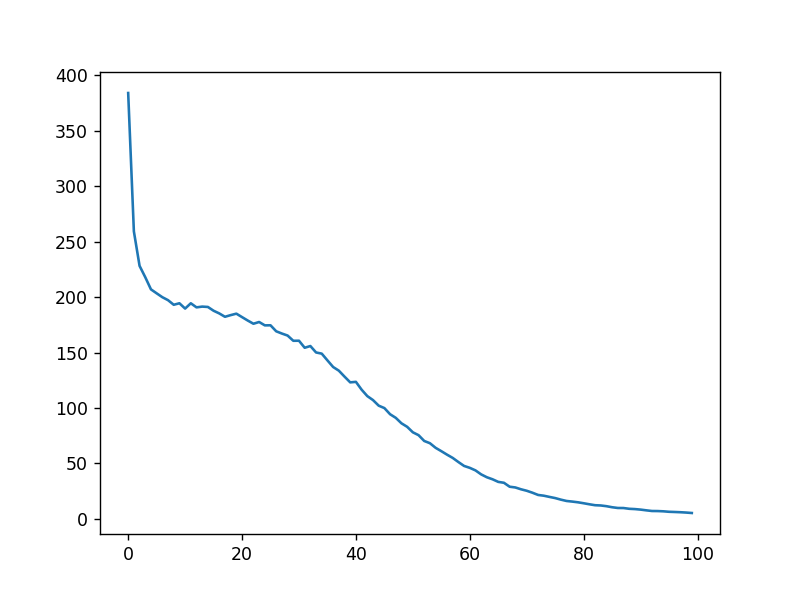

In [28]:
%matplotlib notebook
plt.plot(ppl_list)

### RNNLM의 Trainer 클래스

In [29]:
from common.trainer import RnnlmTrainer